# Accumulated and Performance Score Methods: A comparative approach

Common game score systems consists in assigning points on individual players that in team scores are reflected as the accumulated (and weighted) sum of this points. A common practice is to assign players to random teams for equal distribution, wich will work well when teams don't represent any symbol that has special meaning to the players. The main problem that may cause negative environments and behaviors between players with this system is precisely when teams represent something meaningful to them (be it game lore, favouritism, etc.), causing frustration, discrimination and lack of interest, with latent desires of supporting teams in small collectives (group of friends) and freedom to choose (posibility to change to other teams).

Here is developed a simple proposal to change the calculus of the main accumulative score system to a distributive (or normalized) score system for games where teams have a symbolic meaning to players, evaluating a team by its performances instead, recognizing pros and cons to consider before implementing:

*Pros*
- give freedom to players to choose a side
- easy to interpret from evaluating point of view, e.g., 3 out of 10 players won highest score in the event
- easy to compare between teams, normalizing each team distribution separately
- balance escenarios in wich teams have different sizes to prevent leading to biased results with increment of negative perception from the player base

*Cons*
- has a medium complexity not often used for user visualization
- needs additional explanation with a friendly user approach to avoid conflict if teams distributions (or sizes) are notably unbalanced (e.g. the largest team may not understand why a smaller team is favoured if no explanation is provided)

Since is not common to find this approach in medium to large scale, it is expected to work in a practical escenario when users are actually playing in small groups (be it 3, 8 or 10 players in one event), then the expected perception will be 'Team A has more/less skilled players than Team B' rather than 'Because Team A has more/less players, is no surprise they would win/lose against Team B'

In [1]:
%%time
import numpy as np
from random import randint, shuffle
import time
import datetime
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# set import para bokeh (funciona como un seaborn interactivo)
#from bokeh.io import output_notebook, show
#from bokeh.resources import INLINE
#from bokeh.plotting import figure
#output_notebook(INLINE)
#output_notebook()

# ignore UserWarning (basically for dataframe filtering)
import warnings
warnings.simplefilter("ignore", UserWarning)
#import the_module_that_warns

# visualisation category config
medal_order = {'medal' : ['gold', 'silver', 'bronze', 'not played']}
medal_colors = ['rgb(255, 222, 94)', 'rgb(169, 180, 195)', 'rgb(194, 144, 80)', 'rgb(0,0,0)']

CPU times: user 14.1 s, sys: 0 ns, total: 14.1 s
Wall time: 10.7 s


## Creating simulated data functions

### Single player

In [2]:
def player_score(player_id = randint(10000, 99999), date = datetime.date.today().isoformat()):
    """
    Creates a DataFrame with a single random player and scores for each event (game)

    **Parameters**
    player_id: player unique identifier
    date: date in YYYY-MM-DD (today by default)
    """
    player = pd.DataFrame(
        {
            'player_id'  : [f"{player_id}" for i in range(2)],
            'event_date' : [date for i in range(2)],
            'event_game' : ['A','B'],
            'score'      : [randint(0,3) for i in range(2)]
        }
    )

    return player

### Team with multiple players

In [3]:
# for creating a team with simulated scores

def team_players(player_id= [randint(10000,99999)], date = datetime.date.today().isoformat()):

    """
    Creates a team score data with a given list of players with random scores for each event.
    """
    
    # creates a dataframe with the first player on list (player_id)
    team = player_score(player_id[0], date)
    
    # if more players on list, it will concatenate this new players (from team_player[1])
    if len(player_id) > 1:
        for player in range(1, len(player_id)):
            team = pd.concat([team, # main dataframe
                              pd.DataFrame( # the other players
                                  {
                                      'player_id'  : [f"{player_id[player]}" for i in range(2)],
                                      'event_date' : [date for i in range(2)],
                                      'event_game' : ['A', 'B'],
                                      'score'  : [randint(0,3) for i in range(2)]
                                  }
                              ) 
                             ])
    # reindex de filas
    team.reset_index(drop = True, inplace = True)
    
    return team

### Describing scores

In [4]:
# making a more fancy representation of scores: create a categorical column

def team_scores(player_id = [randint(10000,99999)], date = datetime.date.today().isoformat()):
    """
    Creates a team score data with a given list of players with random scores
    for each event, and asigns score description.
    """

    team = team_players(player_id, date)

    medal = []

    for s in team['score'].values:
        if s == 1:
            medal.append('bronze')
        elif s == 2:
            medal.append('silver')
        elif s == 3:
            medal.append('gold')
        else:
            medal.append('not played')

    team['medal'] = pd.Categorical(medal, categories=['not played', 'bronze', 'silver', 'gold'], ordered=False)

    return team

## Creating teams from unique player ID

### Configuring input for user defined values

In [5]:
# players id, unsorted, unique
# the player_base must be defined by the user to test escenarios

#------------------------------- n players in player base
n_player_base = 611 #6114 #100
#------------------------------- max player ids: 99999
player_ids = [i for i in range(10000,100000)]
shuffle(player_ids)
#------------------------------- cuts list with indexing
player_ids = player_ids[:n_player_base]

# amount of players by team (add streamlit checkbox)
input_a = 184 #1842 #27
input_b = 236 #2357 #12
input_c = 81 #810 #27
# input_d = len(player_base) - (input_a + input_b + input_c) # replaced by d_pl

print(f"Users in events: {len(player_ids)} users")

Users in events: 611 users


In [6]:
# team name input for streamlit
#--------- for default teams
team_names_input = ['ThunderCats', 'Dog Patrol', 'Power Birds', 'Go Magikarp']
#--------- user defined teams example
#team_names_input = ['Daylight Prairie', 'Hidden Forest', 'Valley of Triumph', 'Golden Wasteland']

# date input for Streamlit
#date = datetime.date.today().isoformat()
date = datetime.date(2024, 8, 15).isoformat()

In [7]:
# player leftover sequence
# useful to visualize when testing n players

b_pl = n_player_base - input_a
c_pl = n_player_base - (input_a + input_b)
d_pl = n_player_base - (input_a + input_b + input_c)

b_pl, c_pl, d_pl#, b_pl+c_pl+d_pl

(427, 191, 110)

### Streamlit checkbox simulation

In [8]:
# checbox: if cb_b == true, appears cb_c == False
# checbox: if cb_b == false, cb_c remains hidden
cb_b = True
cb_c = True
cb_d = False

In [9]:
# player distribution through all teams, sorted, rectified
# teams b, c and d must be unlocked in the app (if checkbox b/c/d marked (True): create team b/c/d)

# team B n players
if cb_b == True:
    if input_b <= b_pl and b_pl >= 1:
        team_b = input_b
    else:
        team_b = 0

# team C n players
if cb_c == True:
    if input_c <= c_pl and c_pl >= 1:
        team_c = input_c
    else:
        team_c = 0
else:
    team_c = 0

# team D n players
if cb_d == True:
    #if input_d <= d_pl and d_pl >= 1:
    if d_pl >= 1:
        team_d = d_pl
    else:
        team_d = 0
else:
    team_d = 0

print(f"""Team A: {input_a}\nTeam B: {team_b}\nTeam C: {team_c}\nTeam D: {team_d}\nTotal users: {input_a+team_b+team_c+team_d}""")

Team A: 184
Team B: 236
Team C: 81
Team D: 0
Total users: 501


In [10]:
# users in each team
team_a_players = player_ids[:input_a]
team_b_players = player_ids[input_a:len(team_a_players)+team_b]
team_c_players = player_ids[len(team_b_players):len(team_b_players)+team_c]
team_d_players = player_ids[len(team_c_players):len(team_c_players)+team_d]

# verify team lengths (from inputs and checkboxes)
len(team_a_players), len(team_b_players), len(team_c_players), len(team_d_players)

(184, 236, 81, 0)

### Render players dataframe and teams aggregated dataframe

In [11]:
# build DataFrame (no date input yet)

#------------------------------------------ team A
#team_a_players = player_base[:input_a]
df_team_a = team_scores(player_id = team_a_players, date = date)
df_team_a['team'] = pd.Series([team_names_input[0] for i in range(len(df_team_a))])
# for accumulative sum method demonstration
df_eventplayers = df_team_a.copy()

# builds a total_players list for df (team a by default)
total_players = [input_a for i in range(3)]

#------------------------------------------ team B 
#if len(team_b_players) > 0:
if cb_b == True:
    #team_b_players = player_base[input_a:len(team_a_players)+team_b]
    df_team_b = team_scores(player_id = team_b_players, date = date)
    df_team_b['team'] = pd.Series([team_names_input[1] for i in range(len(df_team_b))])
    df_eventplayers = pd.concat([df_eventplayers, df_team_b]).reset_index(drop=True)
    
    # appends team b players
    total_players.extend([team_b for i in range(3)])
#------------------------------------------ team C
#if len(team_c_players) > 0:
if cb_c == True:
    #team_c_players = player_base[len(team_b_players):len(team_b_players)+team_c]
    df_team_c = team_scores(player_id = team_c_players, date = date)
    df_team_c['team'] = pd.Series([team_names_input[2] for i in range(len(df_team_c))])
    df_eventplayers = pd.concat([df_eventplayers, df_team_c]).reset_index(drop=True)

    # appends team c players
    total_players.extend([team_c for i in range(3)])
    
#------------------------------------------ team D
#if len(team_d_players) > 0:
if cb_d == True:
    #team_d_players = player_base[len(team_c_players):len(team_c_players)+team_d]
    df_team_d = team_scores(player_id = team_d_players, date = date)
    df_team_d['team'] = pd.Series([team_names_input[3] for i in range(len(df_team_d))])
    df_eventplayers = pd.concat([df_eventplayers, df_team_d]).reset_index(drop=True)

    # appends team d players
    total_players.extend([team_d for i in range(3)])

# all players in one dataframe
df_eventplayers#.head(3)

,player_id,event_date,event_game,score,medal,team
0,16803,2024-08-15,A,2,silver,ThunderCats
1,16803,2024-08-15,B,1,bronze,ThunderCats
2,92610,2024-08-15,A,0,not played,ThunderCats
3,92610,2024-08-15,B,3,gold,ThunderCats
4,99898,2024-08-15,A,2,silver,ThunderCats
...,...,...,...,...,...,...
997,92635,2024-08-15,B,3,gold,Power Birds
998,31884,2024-08-15,A,2,silver,Power Birds
999,31884,2024-08-15,B,2,silver,Power Birds
1000,16706,2024-08-15,A,1,bronze,Power Birds


## Accumulative Method

This method will consider only a weighted sum of scores, the more players the team has, it will accumulate more medals, considering some players won't participate in both events.

In [12]:
# accumulated, weighted scores (keeping dataframe integrity)
df_eventteams_scores = df_eventplayers.groupby(['event_date', 'event_game', 'team', 'medal']).sum('score').reset_index()

#---------------- frequency (medal count)
acc_f = []
for i in range(len(df_eventteams_scores)):
    if df_eventteams_scores['medal'].iat[i]=='gold':
        acc_f.append(int(df_eventteams_scores['score'].iat[i]/3))
    elif df_eventteams_scores['medal'].iat[i]=='silver':
        acc_f.append(int(df_eventteams_scores['score'].iat[i]/2))
    elif df_eventteams_scores['medal'].iat[i]=='bronze':
        acc_f.append(int(df_eventteams_scores['score'].iat[i]))
    else:
        acc_f.append(0)

df_eventteams_scores['medal_frequence'] = pd.Series(acc_f)

#---------------- weighted scores
df_eventteams_scores['acc_w_score'] = df_eventteams_scores['score']
df_eventteams_scores.drop('score', axis=1, inplace=True)

#---------------- drop 'not played' with filter
df_eventteams_scores = df_eventteams_scores[df_eventteams_scores['medal']!='not played']

#---------------- reorder columns and values by categorical datatypes
df_eventteams_scores['team'] = pd.Categorical(
    values = [i for i in df_eventteams_scores['team'].values],
    categories = [i for i in df_eventplayers['team'].unique()],
    ordered = True)
df_eventteams_scores.sort_values(by=['event_game','team', 'medal'], ascending=[True,True, True], ignore_index=True, inplace=True)

#---------------- set medal column to categorical
df_eventteams_scores['medal'] = pd.Categorical(df_eventteams_scores['medal'],
                                               ordered=True,
                                               categories = ['bronze', 'silver', 'gold'])

#---------------- adds total_players column
total_players.extend(total_players)
df_eventteams_scores = pd.concat([df_eventteams_scores, pd.Series(total_players, name='total_players')], axis=1)

#---------------- team names list (for interactive data visualization)
team_names = [i for i in df_eventplayers['team'].unique()]
events = [i for i in df_eventplayers['event_game'].unique()]

df_eventteams_scores.head(4)

,event_date,event_game,team,medal,medal_frequence,acc_w_score,total_players
0,2024-08-15,A,ThunderCats,bronze,48,48,184
1,2024-08-15,A,ThunderCats,silver,49,98,184
2,2024-08-15,A,ThunderCats,gold,48,144,184
3,2024-08-15,A,Dog Patrol,bronze,53,53,236


**Considerations**

All previews data is autogenerated, so what happens with user data? Some requirements must meet in input data:

- players have asociated relevant data, like resulting event score and other attributes depending on the nature of the game
- in many games, a team can be a faction, a country, class...
- for this score methods, a player score must be part of a batch first, and then compare globaly. For a global score alone, any score method is irrelevant (just sort your scores!).

For this reasons, any new data must pass through a pipeline for this to look like this random sim data.

## Performance Score Method

Separates the individual scoring from team scoring, keeping individual in the accumulative method, and using indibidual resulting position to process each team score, normalizing each team's result distribution.

## Team Metrics

In [13]:
# lets take a look on team ThunderCats (team A) as example
# we will always want some metrics from this simple numbers
# this is our purest information from a single team

print(
    f"""Team A, event A medals
    N of players: {len(team_a_players)}
    Not played:   {len(df_team_a[df_team_a['score']==0][df_team_a['event_game']=='A'][['player_id', 'event_game']])}
    Bronzes:      {len(df_team_a[df_team_a['score']==1][df_team_a['event_game']=='A'][['player_id', 'event_game']])}
    Silvers:      {len(df_team_a[df_team_a['score']==2][df_team_a['event_game']=='A'][['player_id', 'event_game']])}
    Golds:        {len(df_team_a[df_team_a['score']==3][df_team_a['event_game']=='A'][['player_id', 'event_game']])}"""
)

Team A, event A medals
    N of players: 184
    Not played:   39
    Bronzes:      48
    Silvers:      49
    Golds:        48


### Competitors ratio

To have a clear idea of how many players actually played in an event, in proportional terms instead of real frequency. The output requires more information to interpret, it may vary depending on user experience and posible issues during event execution.

In general terms, an output may be related with user experience, but also a team output can be related with community interactions and social experience ingame or in outer .

In [14]:
def competitor_r(total_players, n_players):
    """
    Proportion of players who have participated in an event. Outputs float, can be multiplied by 100.
    total_players: player base
    n_plyers: players who did/didn't participate.
    """
    competitors_ratio = (total_players - n_players) / total_players

    return competitors_ratio

In [15]:
def general_participation(df, n_player_base = n_player_base,
                          #n_players_a = team_a_players, n_players_b = team_b,
                          #n_players_c = team_c, n_players_d = team_d,
                          cb_b = cb_b, cb_c = cb_c, cb_d = cb_d):
    
    """
    General competitor ratios, or player ratios, by event and by team

    **Output**
    List of general events player participation (competitors ratios) and list of general teams participation
    (competitors ratios). Can access to individual values with indexing. Values can be multiplied by 100 for
    relative format.
    
    **Parameters**
    df: dataframe with main data
    n_player_base: all player users
    *kwards: other data related to teams and checkboxes
    """
    
    events = list(df['event_game'].unique())
    event_compr = []

    # users, teams and event participation ratios (we use desagregated dfs)
    #-------------- general ratio
    for event in events:
        event_comp = len(df[df['score']==0][df['event_game']==event])
        event_compr.append(competitor_r(n_player_base, event_comp))
        # can apply round(event_compr*100,2) for value in %
    
    #-------------- team ratios
    #--------------------- team A by default, the rest defined by checkboxes
    team_cr = [competitor_r(len(team_a_players), len(df_team_a[df_team_a['score']==0]))]
    
    if cb_b == True:
        team_b_cr = competitor_r(len(team_b_players), len(df_team_b[df_team_b['score']==0]))
        team_cr.append(team_b_cr)
    if cb_c == True:
        team_c_cr = competitor_r(len(team_c_players), len(df_team_c[df_team_c['score']==0]))
        team_cr.append(team_c_cr)
    if cb_d == True:
        team_d_cr = competitor_r(len(team_d_players), len(df_team_d[df_team_d['score']==0]))
        team_cr.append(team_d_cr)

    return event_compr, team_cr

In [16]:
event_compr, team_cr = general_participation(df_eventplayers)

# general ratio
for e in range(len(events)):
    print(f"Event {events[e]} participation: {round((event_compr[e])*100,2)}%")
print("---------------"*3)

# team ratios (team A by default, the rest defined by checkboxes)
for t in range(len(team_names)):
    print(f"""Team {team_names[t]} participation: {round(team_cr[t]*100,2)}%""")

Event A participation: 81.01%
Event B participation: 81.18%
---------------------------------------------
Team ThunderCats participation: 58.15%
Team Dog Patrol participation: 49.58%
Team Power Birds participation: 56.79%


In [17]:
# estimating event competition ratios per team (team A by default)
# competition ratio (player ratio) is an indicator that will help if in an event ends in a draw
# also, will help learn if an event was succesfull or not and explain other phenomena

def team_event_participation(df, n_players):

    """
    DataFrame with all competitor ratios by team per event

    **Parameters**
    df: dataframe of a single team (no general playerbase)
    n_players: number of players in the team
    """
    
    events = list(df['event_game'].unique())
    event_team_cr = [competitor_r(n_players, len(df[df['score']==0][df['event_game']==event])) for event in events]

    # builds ratio data to append to main team dataframe
    df_event_team_cr = pd.DataFrame({
        'player_ratio' : event_team_cr,
        'event_game'   : events,
        'team'         : [df.at[0,'team'] for i in range(len(events))]
    })
    
    return df_event_team_cr

In [18]:
# first team ratios
df_aux = team_event_participation(df_team_a, input_a)
print(
    f"""Teams Event competitor ratios
    \tTeam {team_names[0]} \t - Event {df_aux['event_game'].unique()[0]}: {round((df_aux.at[0,'player_ratio']*100),2)}%\t Event {df_aux['event_game'].unique()[1]}: {round(df_aux.at[1,'player_ratio']*100,2)}%""")

# the rest of team ratios, concatenated to the first
if cb_b == True: 
    df_aux = pd.concat([df_aux, team_event_participation(df_team_b, team_b)],ignore_index=True)
    print(f"\tTeam {team_names[1]} \t - Event {df_aux['event_game'].unique()[0]}: {round(df_aux.at[2,'player_ratio']*100,2)}%\t Event {df_aux['event_game'].unique()[1]}: {round(df_aux.at[3,'player_ratio']*100,2)}%")
if cb_c == True:
    df_aux = pd.concat([df_aux, team_event_participation(df_team_c, team_c)],ignore_index=True)
    print(f"\tTeam {team_names[2]} \t - Event {df_aux['event_game'].unique()[0]}: {round(df_aux.at[4,'player_ratio']*100,2)}%\t Event {df_aux['event_game'].unique()[1]}: {round(df_aux.at[5,'player_ratio']*100,2)}%")
if cb_d == True:
    df_aux = pd.concat([df_aux, team_event_participation(df_team_d, team_d)],ignore_index=True)
    print(f"\tTeam {team_names[3]} \t - Event {df_aux['event_game'].unique()[0]}: {round(df_aux.at[6,'player_ratio']*100,2)}%\t Event {df_aux['event_game'].unique()[1]}: {round(df_aux.at[7,'player_ratio']*100,2)}%")

# appends auxiliar df with competitor ratios (player ratio) to main team scores df
df_eventteams_scores = pd.merge(
    left=df_eventteams_scores,
    right = df_aux,
    how = 'inner',
    on = ['event_game', 'team'])

# formats player ratio
df_eventteams_scores['player_ratio'] = (df_eventteams_scores['player_ratio']*100).round(2)

# player ratio seems like duplicated data but its based on team, not on medals, helping on data visualization
df_eventteams_scores.head(4)

Teams Event competitor ratios
    	Team ThunderCats 	 - Event A: 78.8%	 Event B: 79.35%
	Team Dog Patrol 	 - Event A: 73.31%	 Event B: 76.27%
	Team Power Birds 	 - Event A: 82.72%	 Event B: 74.07%


,event_date,event_game,team,medal,medal_frequence,acc_w_score,total_players,player_ratio
0,2024-08-15,A,ThunderCats,bronze,48,48,184,78.80
1,2024-08-15,A,ThunderCats,silver,49,98,184,78.80
2,2024-08-15,A,ThunderCats,gold,48,144,184,78.80
3,2024-08-15,A,Dog Patrol,bronze,53,53,236,73.31


### Team medals relative frequencies

Lets estimate the percentage of medals won by each team in each event, since having only frecuency is not enough to compare between teams. With this we will have something like "$n$ out of 10 players won $m$ medal"

In [19]:
# here are used 3 functions

#----------- Medal relative frequence function optimizations (indirect use)
# medal proportion, by team
def medal_r(team_players, n_gold, n_silver, n_bronze):
    """
    Proportion of medals won.
    Team_players: int
    medals (n_gold, n_silver, n_bronze): int
    """
    goldm = n_gold / team_players
    silvm = n_silver / team_players
    bronm = n_bronze / team_players

    return goldm, silvm, bronm

# medal proportion, by team and event
def event_medal_r(team_players_df, event):
    """
    Proportion of medals won, counting from a DataFrame an filtering by event
    """
    competitors = int((len(team_players_df)/2)-len(team_players_df[team_players_df['score']==0][team_players_df['event_game']==event]))
    n_gold = len(team_players_df[team_players_df['score']==3][team_players_df['event_game']==event])
    n_silv = len(team_players_df[team_players_df['score']==2][team_players_df['event_game']==event])
    n_bron = len(team_players_df[team_players_df['score']==1][team_players_df['event_game']==event])

    gold, silver, bronze = medal_r(competitors, n_gold, n_silv, n_bron)
    
    return gold, silver, bronze

#----------- Direct use in Streamlit
# build auxiliar medal df to concatenate with main df 
def team_event_medals(df_team, main_df = df_eventteams_scores):
    """
    Builds df of medal relative frequence by team and event.
    
    Parameters
    df: team dataframe (not general)
    """
    # builds auxiliar df with medal relative count (from team A by default)
    
    events = list(main_df['event_game'].unique())
    aux_data = list(event_medal_r(df_team, events[0])[:])

    # creates a list of events based on medal colors (winning positions)
    aux_events = [events[0] for e in range(len(main_df['medal'].unique()))]
    aux_medals = ['gold', 'silver', 'bronze']
    #for i in range(len(events)):
        
    for i in range(1,len(events)):
        aux_events.extend([events[i] for e in range(len(main_df['medal'].unique()))])
        aux_data.extend(list(event_medal_r(df_team, events[i])[:]))
        aux_medals.extend(aux_medals)
    

    df_aux = pd.DataFrame({
        'event_game'     : aux_events,
        'team'           : [df_team['team'].unique()[0] for i in range(len(aux_events))],
        'medal'          : ['gold', 'silver', 'bronze', 'gold', 'silver', 'bronze'],
        'medal_relative' : aux_data})

    return df_aux

In [20]:
# teams medal relative frequency in each event, estimated by each team
# this way, it doesn't matter how many players are in each team, but how players performed in relative terms
# here is where the method unbias the results, since results are independent from player count in a large playerbase
# also, it considers players that actually participated in each event

# builds auxiliar df with medal relative count (from team A by default)
df_aux = team_event_medals(df_team_a)

if cb_b == True:
    df_aux = pd.concat([df_aux, team_event_medals(df_team_b)])
if cb_c == True:
    df_aux = pd.concat([df_aux, team_event_medals(df_team_c)])
if cb_d == True:
    df_aux = pd.concat([df_aux, team_event_medals(df_team_d)])

# appends relative frequencies to main team data
df_eventteams_scores = pd.merge(
    left=df_eventteams_scores,
    right = df_aux,
    how = 'inner',
    on = ['event_game', 'team', 'medal'])

#formats float values
df_eventteams_scores['medal_relative'] = df_eventteams_scores['medal_relative'].round(4)

df_eventteams_scores.head(4)

,event_date,event_game,team,medal,medal_frequence,acc_w_score,total_players,player_ratio,medal_relative
0,2024-08-15,A,ThunderCats,bronze,48,48,184,78.80,0.3310
1,2024-08-15,A,ThunderCats,silver,49,98,184,78.80,0.3379
2,2024-08-15,A,ThunderCats,gold,48,144,184,78.80,0.3310
3,2024-08-15,A,Dog Patrol,bronze,53,53,236,73.31,0.3064


In [21]:
# lets compare only teams A and B in event A
print(
    f"""Teams Performance ratios during each event
Event A
    \tTeam ThunderCats\t - Gold: {(df_eventteams_scores[df_eventteams_scores['event_game']=='A'][df_eventteams_scores['team']=='ThunderCats'][df_eventteams_scores['medal']=='gold']['medal_relative']*100).iloc[0]}%\t Silver: {(df_eventteams_scores[df_eventteams_scores['event_game']=='A'][df_eventteams_scores['team']=='ThunderCats'][df_eventteams_scores['medal']=='silver']['medal_relative']*100).iloc[0]}%
    \tTeam Dog Patrol \t - Gold: {(df_eventteams_scores[df_eventteams_scores['event_game']=='A'][df_eventteams_scores['team']=='Dog Patrol'][df_eventteams_scores['medal']=='gold']['medal_relative']*100).iloc[0]}%\t Silver: {((df_eventteams_scores[df_eventteams_scores['event_game']=='A'][df_eventteams_scores['team']=='Dog Patrol'][df_eventteams_scores['medal']=='silver']['medal_relative'])*100).iloc[0]}%""")

Teams Performance ratios during each event
Event A
    	Team ThunderCats	 - Gold: 33.1%	 Silver: 33.79%
    	Team Dog Patrol 	 - Gold: 33.53%	 Silver: 35.839999999999996%


### Performance score

All new counts are put together, now we need the final performance score from medal relative frequence and build a 2 score columns for visualization purpose.

In [22]:
# first lets build the last medal scores using relative frequencies with the same weights

perf_s = []
for i in range(len(df_eventteams_scores)):
    if df_eventteams_scores['medal'].iat[i]=='gold':
        perf_s.append(round(df_eventteams_scores['medal_relative'].iat[i]*300,2))
    elif df_eventteams_scores['medal'].iat[i]=='silver':
        perf_s.append(round(df_eventteams_scores['medal_relative'].iat[i]*200,2))
    elif df_eventteams_scores['medal'].iat[i]=='bronze':
        perf_s.append(round(df_eventteams_scores['medal_relative'].iat[i]*100,2))
    else:
        perf_s.append(0)

df_eventteams_scores['performance_score'] = pd.Series(perf_s)

# formats medal_relative after score
df_eventteams_scores['medal_relative'] = (df_eventteams_scores['medal_relative']*100).apply(lambda x: int(x))

df_eventteams_scores.head(4)

,event_date,event_game,team,medal,medal_frequence,acc_w_score,total_players,player_ratio,medal_relative,performance_score
0,2024-08-15,A,ThunderCats,bronze,48,48,184,78.80,33,33.10
1,2024-08-15,A,ThunderCats,silver,49,98,184,78.80,33,67.58
2,2024-08-15,A,ThunderCats,gold,48,144,184,78.80,33,99.30
3,2024-08-15,A,Dog Patrol,bronze,53,53,236,73.31,30,30.64


In [23]:
# add total score totals to main team score df

df_aux = df_eventteams_scores[['event_game', 'team','acc_w_score','performance_score']].groupby(['event_game','team']).sum(['acc_w_score','performance_score']).reset_index()
df_aux.columns = ['event_game', 'team', 'acc_w_score_total', 'performance_score_total']

df_eventteams_scores = pd.merge(
    left = df_eventteams_scores, right = df_aux,
    how = 'inner', on = ['event_game', 'team'])


df_eventteams_scores.head(4)

,event_date,event_game,team,medal,medal_frequence,acc_w_score,total_players,player_ratio,medal_relative,performance_score,acc_w_score_total,performance_score_total
0,2024-08-15,A,ThunderCats,bronze,48,48,184,78.80,33,33.10,290,199.98
1,2024-08-15,A,ThunderCats,silver,49,98,184,78.80,33,67.58,290,199.98
2,2024-08-15,A,ThunderCats,gold,48,144,184,78.80,33,99.30,290,199.98
3,2024-08-15,A,Dog Patrol,bronze,53,53,236,73.31,30,30.64,351,202.91


## Defining winners

Now that we can see the difference between acumulative score and performance by normalizing every team, the final question is: *how can we tell if a team won gold, silver or bronze in an event?* Lets explore some ways.

### Sorting values

By observing the performance figure, can be seen the teams who won more gold, silver and bronze medals.

By sorting the data jerarquically, considering as a first instance to define a winner one of the total scores (performance or accumulative), then the team that has a 'best quality' score (e.g. more gold than silver, or the one who made more kills and/or died less times), and if those don't suffice, a comparison between competitor (player) ratios (can be non participants or deserters).

Its important to keep performance score in a relative scale already estimated, the same with accumulative score since it's in real scale.

In [24]:
def event_winners(score_type = 'accumulative', df = df_eventteams_scores):

    """
    Shows the winners sorted by total score > medal score > competitor ratio (or player ratio).

    **Parameters**
    score_type: choose 'performance' or 'accumulative' ('accumulative' by default)
    df: main DataFrame
    """

    team_names = list(df['team'].unique())
    loc_index = [i*2 for i in range(len(team_names))]

    if score_type == 'accumulative':
        score_cols = ['acc_w_score_total', 'acc_w_score']
    if score_type == 'performance':
        score_cols = 'performance_score_total', 'performance_score'

    events = list(df['event_game'].unique())

    observed_winners = df[df['event_game']==events[0]][df['medal']!='bronze'].copy()\
                        .sort_values(by = [score_cols[0], score_cols[1], 'player_ratio'],
                                     ascending = [False, False, False])\
                       [['event_game','team','medal',score_cols[0], score_cols[1],'player_ratio']]\
                       .reset_index(drop=True).iloc[loc_index,:]

    if len(events)>1:
        for e in range(1,len(events)):
            observed_winners = pd.concat([observed_winners,df[df['event_game']==events[e]][df['medal']!='bronze']\
                                .sort_values(by = [score_cols[0], score_cols[1], 'player_ratio'],
                                             ascending = [False, False, False])\
                               [['event_game','team','medal',score_cols[0], score_cols[1],'player_ratio']]\
                               .reset_index(drop=True).iloc[loc_index,:]])

    return observed_winners

In [25]:
event_winners(score_type = 'accumulative')

,event_game,team,medal,acc_w_score_total,acc_w_score,player_ratio
0,A,Dog Patrol,gold,351,174,73.31
2,A,ThunderCats,gold,290,144,78.80
4,A,Power Birds,gold,128,54,82.72
0,B,Dog Patrol,gold,358,183,76.27
2,B,ThunderCats,gold,304,171,79.35
4,B,Power Birds,gold,118,66,74.07


In [26]:
event_winners(score_type = 'performance')

,event_game,team,medal,performance_score_total,performance_score,player_ratio
0,A,Dog Patrol,gold,202.91,100.59,73.31
2,A,ThunderCats,gold,199.98,99.30,78.80
4,A,Power Birds,gold,191.05,80.61,82.72
0,B,ThunderCats,gold,208.22,117.12,79.35
2,B,Dog Patrol,gold,198.89,101.67,76.27
4,B,Power Birds,gold,196.67,110.01,74.07


In [27]:
# da winners! (from 3 teams or more)

print(
    f"""Winners by methods
Event A\t\tAcc_w method\t\tPerformance method
    gold\t{list(list(event_winners(score_type = 'accumulative')['team']))[0]}\t\t{list(list(event_winners(score_type = 'performance')['team']))[0]}
    silver\t{list(event_winners(score_type = 'accumulative')['team'])[1]}\t\t{list(event_winners(score_type = 'performance')['team'])[1]}
    bronze\t{list(event_winners(score_type = 'accumulative')['team'])[2]}\t\t{list(event_winners(score_type = 'performance')['team'])[2]}
Event B
    gold\t{list(event_winners(score_type = 'accumulative')['team'])[3]}\t\t{list(event_winners(score_type = 'performance')['team'])[3]}
    silver\t{list(event_winners(score_type = 'accumulative')['team'])[4]}\t\t{list(event_winners(score_type = 'performance')['team'])[4]}
    bronze\t{list(event_winners(score_type = 'accumulative')['team'])[5]}\t\t{list(event_winners(score_type = 'performance')['team'])[5]}""")

Winners by methods
Event A		Acc_w method		Performance method
    gold	Dog Patrol		Dog Patrol
    silver	ThunderCats		ThunderCats
    bronze	Power Birds		Power Birds
Event B
    gold	Dog Patrol		ThunderCats
    silver	ThunderCats		Dog Patrol
    bronze	Power Birds		Power Birds


## Comparative plots

Resuming all results, a notable difference will be noticed.

In [28]:
# main score df view
df_eventteams_scores

,event_date,event_game,team,medal,medal_frequence,acc_w_score,total_players,player_ratio,medal_relative,performance_score,acc_w_score_total,performance_score_total
0,2024-08-15,A,ThunderCats,bronze,48,48,184,78.80,33,33.10,290,199.98
1,2024-08-15,A,ThunderCats,silver,49,98,184,78.80,33,67.58,290,199.98
2,2024-08-15,A,ThunderCats,gold,48,144,184,78.80,33,99.30,290,199.98
3,2024-08-15,A,Dog Patrol,bronze,53,53,236,73.31,30,30.64,351,202.91
4,2024-08-15,A,Dog Patrol,silver,62,124,236,73.31,35,71.68,351,202.91
5,2024-08-15,A,Dog Patrol,gold,58,174,236,73.31,33,100.59,351,202.91
6,2024-08-15,A,Power Birds,bronze,24,24,81,82.72,35,35.82,128,191.05
7,2024-08-15,A,Power Birds,silver,25,50,81,82.72,37,74.62,128,191.05
8,2024-08-15,A,Power Birds,gold,18,54,81,82.72,26,80.61,128,191.05
9,2024-08-15,B,ThunderCats,bronze,45,45,184,79.35,30,30.82,304,208.22


### Bar/Scatter comparative figures

In [39]:
# create an aux list o lists to flexibilize the code (indirect function)

def marker_size(df, score_type, score_columns, scale):

    """
    Returns a list of lists to give marker size according to total scores. Use solely in score_figure function
    """
    
    l_aux = []
    l_subaux = []
    # first list groups total scores per event, all scores are in the same list
    for e in range(len(events)):
        l_subaux.extend([(df[df['event_game']== events[e]][score_columns[2]]).to_list()])
        if len(events)<2:
            if e == len(events):
                break
        elif len(events)>=2:
            if e == len(events) -1:
                break
        l_aux.append(l_subaux)

    # empty list of lists for 2nd for
    l_score_size = [[] for e in range(len(events))]
    
    # iterates through the auxiliar list to group scores by team, by event
    # the result is list[event idx][team idx]
    for e in range(len(events)):
        # first and last indexes
        first = 0
        last = 3
    
        if score_type == 'accumulative':
            l_score_size[e] = []
        # mask for each team score
        for t in range(len(team_names)):
            #print(first, last)
            #print(l_aux[0][e][first:last])
            l_score_size[e].extend([l_aux[0][e][first:last]])
            first = first + 3
            last  = last + 3
    
    for e in range(len(events)):
        if score_type == 'accumulative':
            l_score_size[e] = [[s/scale for s in sl] for sl in l_score_size[e]]
        if score_type == 'performance':
            l_score_size[e] = [[s/10 for s in sl] for sl in l_score_size[e]]
    
    return l_score_size

In [49]:
# creates a function to plot score data for each team

def score_figure(df, score_type, scale=1, scatter_opacity=1, width = 900, height = 400):

    """
    Creates an interactive figure with subplots for each event and team. Can work for a single event
    or many, as for a single team or many.

    Parameters
    df: DataFrame containing all data features developed
    score_type: set 'accumulative' or 'performance'. If 'accumulative', will plot traditional scoring,
                if 'performance', will plot proposed scoring method based on medal relative frequency,
                ignoring team size.
    scale: set scale for scatter bubbles when score_type is 'accumulative' (1 by default). If score_type
                is set to 'performance', scatter bubbles scale multiplier is 0.1
    scatter_opacity: set a float from 0 to 1, changes scatter bubbles opacity (1 by default)
    """

    # score_type selector
    if score_type == 'accumulative':
        score_columns = ['medal_frequence', 'acc_w_score', 'acc_w_score_total']
    elif score_type == 'performance':
        score_columns = ['medal_relative', 'performance_score', 'performance_score_total']
    #---------------------------------------- build figure
    # team list
    team_names = [i for i in df['team'].unique()]
    # event list
    events = [i for i in df['event_game'].unique()]
    # subplots config
    score_fig = make_subplots(rows= len(events), cols= len(team_names),
                            shared_xaxes = True,
                            shared_yaxes=True,
                            column_titles= team_names,
                            print_grid=False,
                            specs = [[{"secondary_y" : True} for t in range(len(team_names))] for e in range(len(events))])
    #---------------------------------------- build graphs
    l_marker_size = marker_size(df = df, score_type = score_type, score_columns = score_columns, scale = scale)
    for e in range(len(events)):
        for i in range(len(team_names)):
    #----------------------- traces: bar accumulative score values per medal
            score_fig.add_trace(
                go.Bar(
                    x = df[df['event_game']== events[e]][df['team']==team_names[i]]['medal'].map(lambda x : x.capitalize()),
                    y = df[df['event_game']== events[e]][df['team']==team_names[i]][score_columns[0]].values,
                    name = '<b>Event '+ events[e] +'</b>',
                    marker_color = [medal_colors[2], medal_colors[1],medal_colors[0], medal_colors[3]],
                    opacity = 0.8,
                    text = df[df['event_game']== events[e]][df['team']==team_names[i]][score_columns[0]].values,
                    textposition = 'inside',
                    textangle = 0,
                    textfont_color = 'black',
                    customdata = df[df['event_game']== events[e]][df['team']==team_names[i]][['medal_frequence','medal', score_columns[1]]],
                    hovertemplate = '<br><i>Total medals</i>: %{customdata[0]} %{customdata[1]}<br>'+
                                    '<i>Medal score</i>: %{customdata[2]} points',
                ), row = e+1, col = i+1, secondary_y = False)

    #----------------------- traces: scatter accumulative total score values
            score_fig.add_trace(
                go.Scatter(
                    x = df[df['event_game']== events[e]][df['team']==team_names[i]]['medal'].map(lambda x : x.capitalize()),
                    y = df[df['event_game']== events[e]][df['team']==team_names[0]][score_columns[1]],
                    name = '<b>Team metrics</b>',
                    mode = 'markers',
                    marker_size = l_marker_size[e][i],
                    marker_color = [medal_colors[2], medal_colors[1],medal_colors[0]],
                    marker_line_color = 'white',
                    opacity = scatter_opacity,
                    customdata = df[df['event_game']== events[e]][df['team']==team_names[i]][['medal_relative','player_ratio', 'total_players', score_columns[2]]],
                    hovertemplate = '<br><i>Medal distribution</i>: %{customdata[0]}%<br>'+
                                    '<i>Participation</i>: %{customdata[1]}%<br>'+
                                    '<i>Team players</i>: %{customdata[2]}<br>'+
                                    '<br><b>Team Score</b>: %{customdata[3]}'
                ), row = e+1, col = i+1, secondary_y = True)

    #---------------------------------------- fix category orders for 0 values
    score_fig.update_xaxes(
        categoryorder = 'array',
        categoryarray = ['gold', 'silver', 'bronze'],
        showticklabels= False,
        showspikes = False)
    #---------------------------------------- applies secondary y axis for subplots
    score_fig.update_yaxes(
        side = 'right',
        secondary_y = True)
    #---------------------------------------- config: title, legend, hover, template, fig dimensions
    score_fig.update_layout(
        title = f"Event {score_type.capitalize()} scores, by teams, date {df['event_date'].unique()[0]}",
        barmode = 'group',
        showlegend = False,
        hovermode = 'x unified',
        hoverlabel_align = 'right',
        barcornerradius = "50%",
        template = 'plotly_dark',
        width = width, height = height)
    
    #----------------------- 'show' line (return for Streamlit)
    return score_fig

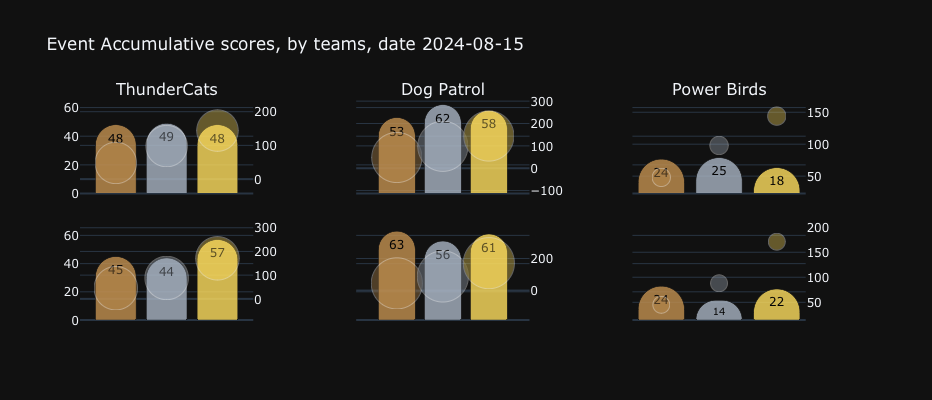

In [50]:
# scatter bubbles at 70% of its size
score_figure(df_eventteams_scores, 'accumulative', 7, scatter_opacity = 0.5)

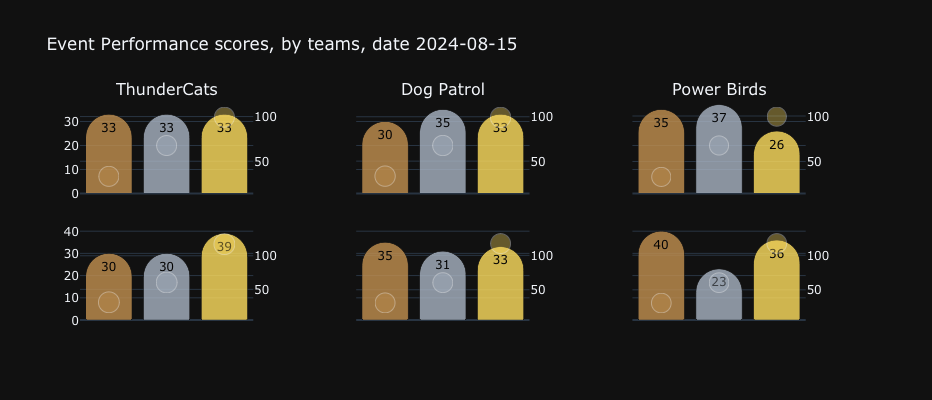

In [48]:
score_figure(df_eventteams_scores, 'performance', scatter_opacity=0.5)

## "Conclusions" (and hipothesis)

After reviewing the calculus and impact of accumulative score system in the escenario wich players are placed in teams with symbolic value, posible solutions are proposed, allowing players to choose freely and estimate winners based on performance, calculating scores by normalizing each team instead of considering all the players without data processing. It's expected to reduce negative impact on the perception from user experience and community perspectives.

Since is not commonly applied or seen, is suggested to do a test event with any of these approaches and observe the impact on players.